https://developer.ibm.com/tutorials/iot-deep-learning-anomaly-detection-5/

This tutorial was using python2 and pre tf2 keras

In [3]:
import keras
import h5py
import ibmiotf

In [6]:
from queue import Queue

In [28]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from  sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ibmiotf.application

import tensorflow as tf


%matplotlib inline

In [29]:
tf.__version__

'2.0.0-rc2'

In [8]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle

rm: watsoniotp.*: No such file or directory
--2019-10-03 08:27:06--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com... 151.101.16.133
Connecting to raw.githubusercontent.com|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

watsoniotp.healthy. 100%[===================>] 190.08K  --.-KB/s    in 0.04s   

2019-10-03 08:27:06 (4.35 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2019-10-03 08:27:06--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com... 151.101.16.133
Connecting to raw.githubusercontent.com|151.101.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185401 (181K) [text/plain]
S

In [9]:
data_healthy = pickle.load(open('watsoniotp.healthy.phase_aligned.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.phase_aligned.pickle', 'rb'), encoding='latin1')

In [10]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

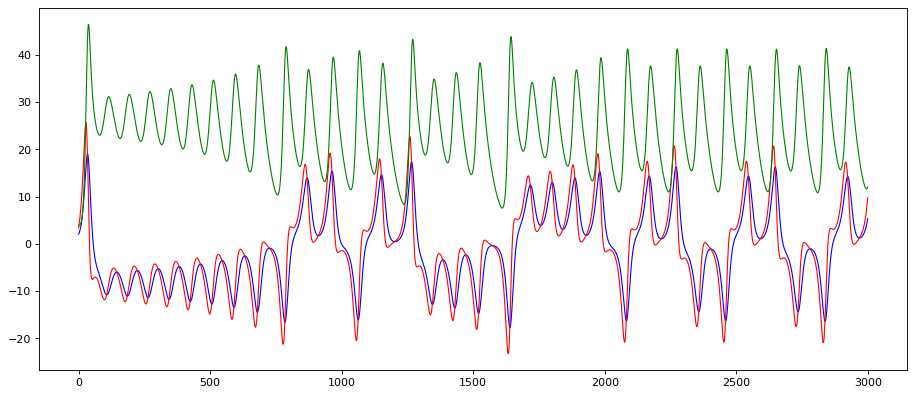

In [11]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)

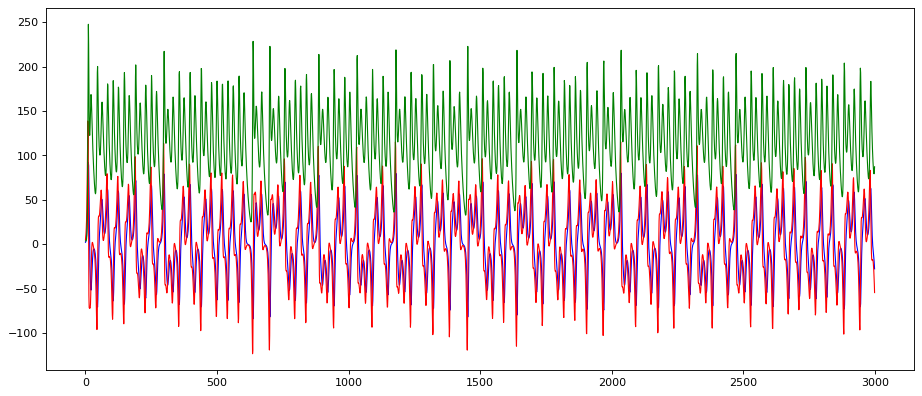

In [12]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)

In [13]:
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

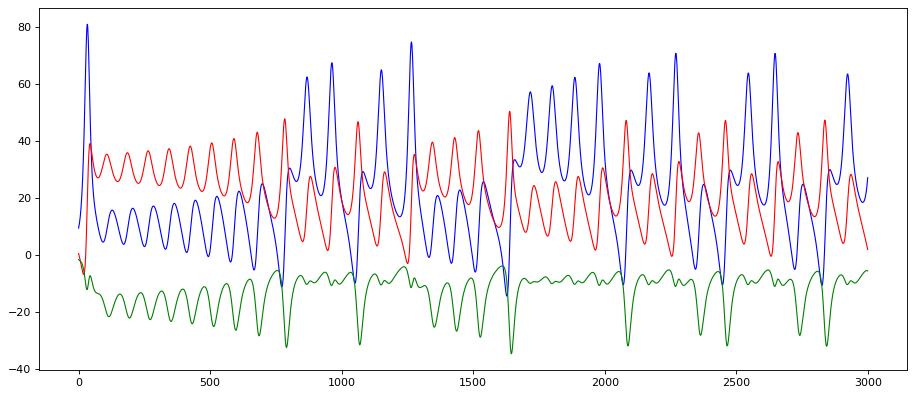

In [14]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


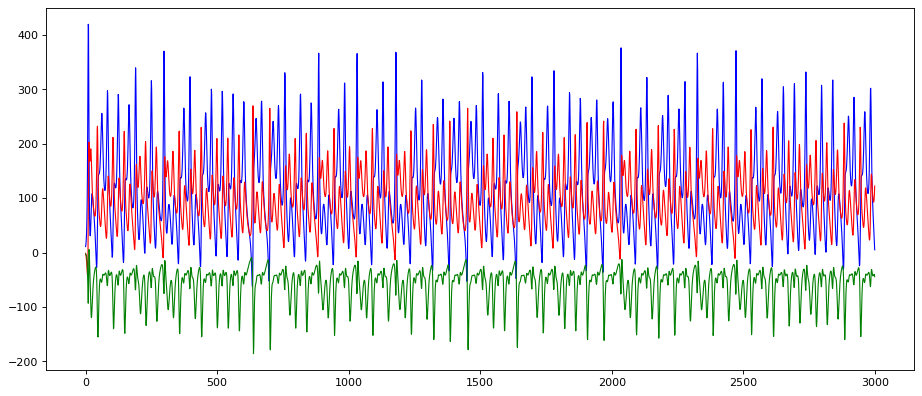

In [15]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)


In [16]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [17]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

In [19]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
#reshape to (300,10,3)
type(data_healthy_scaled_reshaped)

numpy.ndarray

In [21]:
data_healthy_scaled_reshaped.shape

(3000, 3)

In [22]:
#data_healthy_scaled_reshaped.shape = (samples/timesteps,timesteps,dim)

In [24]:
losses = []

def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)

In [25]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

In [30]:
# design network

model = tf.keras.Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=50, batch_size=72, validation_data=(data, data), verbose=0, shuffle=False,callbacks=[LossHistory()])
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat =  model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

RuntimeError: It looks like you are trying to use a version of multi-backend Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or alternatively, downgrading to TensorFlow 1.14.

In [ ]:
for i in range(20):
    
    print "----------------"
    train(data_healthy_scaled)
    yhat_healthy = score(data_healthy_scaled)
    yhat_broken = score(data_broken_scaled)
    data_healthy_scaled.shape = (3000, 3)
    data_broken_scaled.shape = (3000, 3)


print "----------------broken"
train(data_broken_scaled)
yhat_healthy = score(data_healthy_scaled)
yhat_broken = score(data_broken_scaled)
data_healthy_scaled.shape = (3000, 3)
data_broken_scaled.shape = (3000, 3)

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)

In [ ]:
options = {"org": "mh741h", "id": "anything", "auth-method": "apikey", "auth-key": "a-mh741h-hwv6qlpmsv", "auth-token": "zBcbK&rKTfbW*OfneW"}
client = ibmiotf.application.Client(options)
client.connect()

In [ ]:
q = Queue(7000)

In [ ]:
def myEventCallback(event):
    sample = event.data
    point = [sample["x"], sample["y"],sample["z"]]
    q.put(point)

client.deviceEventCallback = myEventCallback
client.subscribeToDeviceEvents("0.16.2", "lorenz", "osc")

In [ ]:
def doNN(data):
    data_scaled = scaleData(data)
    train(data_scaled)
    yhat = score(data_scaled)
    data_scaled.shape = (3000, 3)

In [ ]:
def handleLoss(loss):
        myData={'loss' : str(loss)}
        client.publishEvent("0.16.2", "lorenz", "status", "json", myData)

In [ ]:
import numpy as np
while True:
    while not q.empty():
        point = q.get()
        try:
            data
        except NameError:
            data = np.array(point)
        else:
            data = np.append(data,point)
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print data
            doNN(data)
            del data
